In [16]:
# all libraries needed
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck13
from tqdm import tqdm
import scipy.ndimage
from astropy.io import fits
import random

In [4]:
"""load the dataset"""

# Path to the FITS file
dataset_path = '/Users/mginolfi/Projects/Beta/quasars_spectra_combined.fits'

# Open the FITS file and read the data
with fits.open(dataset_path) as hdu:

    data = hdu[1].data  
    
    # any masking operation can be here
    # data = data[data['REDSHIFT']<2]
    
    # make arrays from spectra and targets
    spectra = data['FLUX']
    loglam = data['LOGLAM']
    dist = data['DIST']
    lo = data['LO']
    lx = data['LX']
    gx = data['GX']
    redshift = data['REDSHIFT']

    # Extract the desired features
    logl1350 = data['LOGL1350']
    logl1700 = data['LOGL1700']
    logl2500 = data['LOGL2500']
    logl3000 = data['LOGL3000']
    logl5100 = data['LOGL5100']
    loglbol = data['LOGLBOL']
    logmbh = data['LOGMBH']
    halpha = data['HALPHA']
    halpha_br = data['HALPHA_BR']
    hbeta = data['HBETA']
    hbeta_br = data['HBETA_BR']
    oiii5007 = data['OIII5007']
    oiii5007c = data['OIII5007C']
    mgii = data['MGII']
    mgii_br = data['MGII_BR']
    civ = data['CIV']

In [5]:
""" Make epxeriment """

# chose the target of insterest



# experiment_target = dist.copy()

experiment_target = lx.copy()

In [6]:
# Combine the features into a single dataset (2D array)
# comment out the features you don't want to include in the model
X = np.column_stack((logl1350, 
                     logl1700, 
                     logl2500, 
                     logl3000, 
                     logl5100, 
                     # loglbol,
                     logmbh, 
                     halpha, 
                     halpha_br,
                     hbeta, 
                     hbeta_br, 
                     oiii5007,
                     oiii5007c, 
                     mgii, 
                     mgii_br, 
                     civ))

Y = experiment_target.copy()

# remove nan values from the dataset to avoid errors in the modeling
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
Y = Y[mask]
redshift = redshift[mask]

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp, redshift_train, redshift_temp = train_test_split(
    X, Y, redshift, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test, redshift_val, redshift_test = train_test_split(
    X_temp, y_temp, redshift_temp, test_size=0.5, random_state=42)


In [8]:
# normalise X and targets

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaler for X
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Scaler for y (if y is a continuous target variable)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# # # Scaler for redshift
scaler_redshift =  MinMaxScaler()
redshift_train = scaler_redshift.fit_transform(redshift_train.reshape(-1, 1)).ravel()
redshift_val = scaler_redshift.transform(redshift_val.reshape(-1, 1)).ravel()
redshift_test = scaler_redshift.transform(redshift_test.reshape(-1, 1)).ravel()


In [9]:
""" MLP """

import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# Spectra input 
spectra_input = tf.keras.Input(shape=(X.shape[1],), name='spectra_input')

# Redshift input
redshift_input = tf.keras.Input(shape=(1,), name='redshift_input')
redshift_layers = tf.keras.layers.Dense(10, activation='selu')(redshift_input)
redshift_layers = tf.keras.layers.Dense(100, activation='selu')(redshift_layers)

# Neural network layers for spectra
spectra_layers = tf.keras.layers.Dense(512, activation='selu')(spectra_input)
spectra_layers = tf.keras.layers.Dense(256, activation='selu')(spectra_layers)
spectra_layers = tf.keras.layers.Dense(128, activation='selu')(spectra_layers)

# Combine spectra and redshift inputs
combined = tf.keras.layers.concatenate([spectra_layers, redshift_layers])

# Continue with more layers as needed
combined_layers = tf.keras.layers.Dense(128, activation='selu')(combined)
combined_layers = tf.keras.layers.Dense(64, activation='selu')(combined_layers)
combined_layers = tf.keras.layers.Dense(32, activation='selu')(combined_layers)


# Output layer for regression
output = tf.keras.layers.Dense(1)(combined_layers)  

# Create the model
model = tf.keras.models.Model(inputs=[spectra_input, redshift_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

model.summary()


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-10-16 14:57:29.951569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-16 14:57:29.951730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 spectra_input (InputLayer)     [(None, 60)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 512)          31232       ['spectra_input[0][0]']          
                                                                                                  
 redshift_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          131328      ['dense_2[0][0]']                
                                                                                              

In [10]:
# Train the model
history = model.fit(
    [X_train, redshift_train], y_train, 
    validation_data=([X_val, redshift_val], y_val), 
    epochs=20, batch_size=1024,
)


Epoch 1/20


2024-10-16 14:57:40.117851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 5s 155ms/step - loss: 0.0994 - val_loss: 0.0272
Epoch 2/20


2024-10-16 14:57:43.978970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 69ms/step - loss: 0.0202 - val_loss: 0.0177
Epoch 3/20
14/14 [==============================] - 1s 67ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 4/20
14/14 [==============================] - 1s 74ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 5/20
14/14 [==============================] - 1s 69ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 6/20
14/14 [==============================] - 1s 71ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 7/20
14/14 [==============================] - 1s 77ms/step - loss: 0.0062 - val_loss: 0.0071
Epoch 8/20
14/14 [==============================] - 1s 75ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 9/20
14/14 [==============================] - 1s 75ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 10/20
14/14 [==============================] - 1s 83ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 11/20
14/14 [==============================] - 1s 65ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 12/20
14/14 [

145/145 [==============================] - 1s 9ms/step - loss: 0.0046
Test Loss: 0.004559040535241365


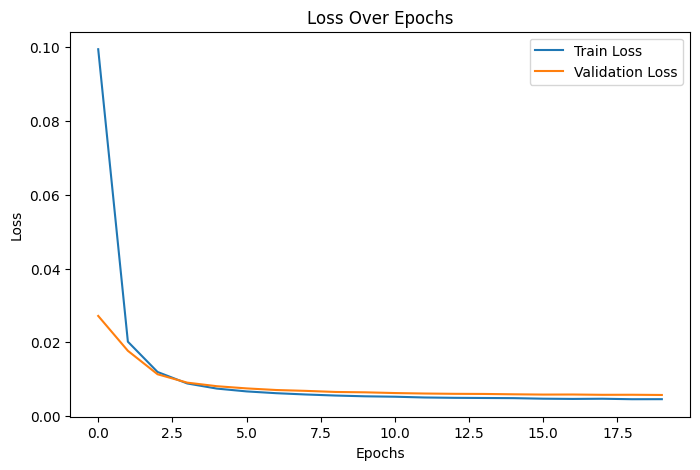

 24/145 [===>..........................] - ETA: 0s

2024-10-16 14:59:09.461721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 1s 7ms/step


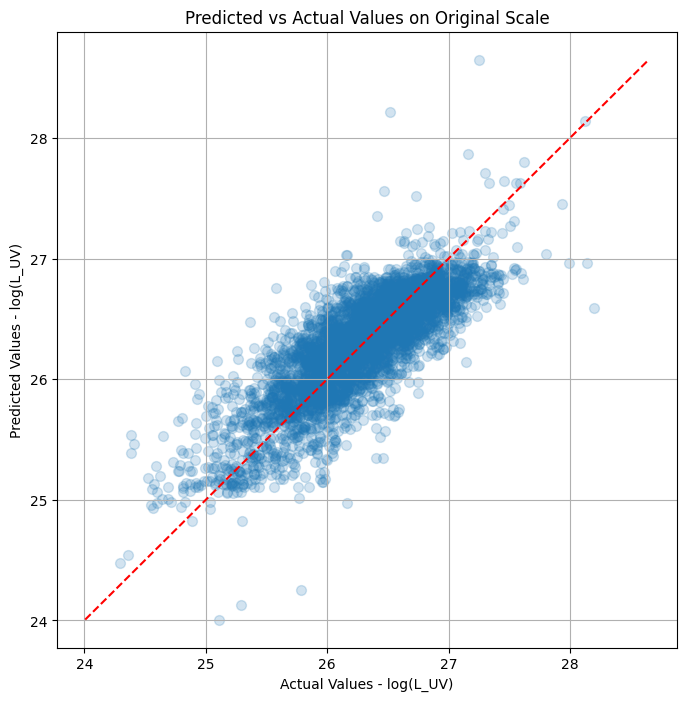

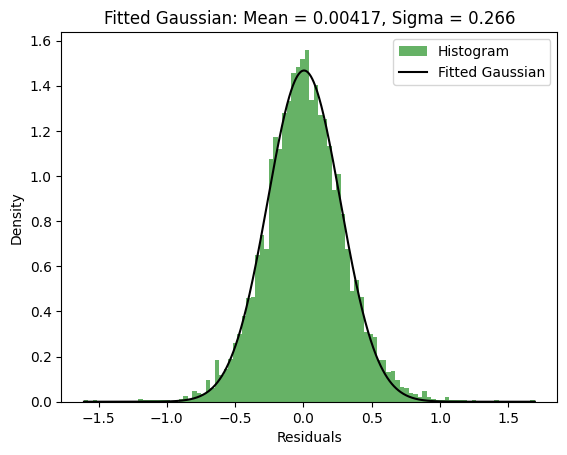

In [11]:
# Evaluate the model
loss = model.evaluate([X_test, redshift_test], y_test)
print(f"Test Loss: {loss}")


import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predict values
y_pred = model.predict([X_test, redshift_test]).flatten()

# Inverse transform the predictions and actual values
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, y_pred_original, alpha=0.2, s=50, )  # Adjust alpha for point transparency
plt.xlabel('Actual Values - log(L_UV)')
plt.ylabel('Predicted Values - log(L_UV)')
plt.title('Predicted vs Actual Values on Original Scale')
plt.grid(True)
# plt.colorbar()

# Line of perfect prediction
min_val = min(y_test_original.min(), y_pred_original.min())
max_val = max(y_test_original.max(), y_pred_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

# Calculate residuals
residuals = y_pred_original - y_test_original


# Create histogram (binned data)
bin_heights, bin_borders, _ = plt.hist(residuals, bins=100, label='Histogram', density=True, alpha=0.6, color='g')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# Fit the Gaussian to the histogram data
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., max(bin_heights), np.std(residuals)])

# Plot the fitted Gaussian
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Fitted Gaussian', color='black')

# Annotate the plot with the Gaussian parameters
plt.title(f'Fitted Gaussian: Mean = {popt[0]:.5f}, Sigma = {popt[2]:.3f}')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

# plt.xlim(-0.2, 0.2)

plt.show()

In [12]:
"""" random forest """""


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# Initialize the Random Forest Regressor with verbose mode
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)

In [13]:
# Train the model
rf_regressor.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [14]:
# Make predictions on the test set
y_pred_scaled = rf_regressor.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


# Inverse transform to get predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
# Also, inverse transform y_test if it was scaled
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

Mean Squared Error: 0.004559041701528399


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


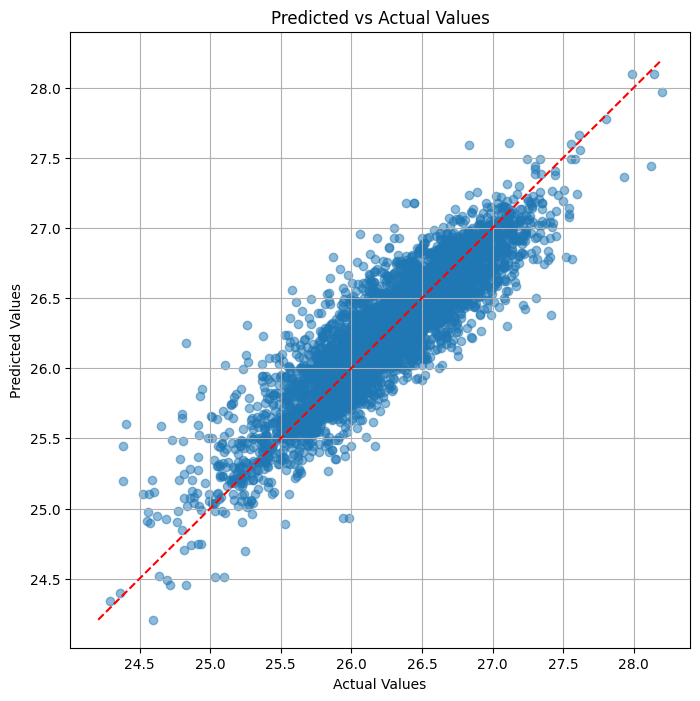

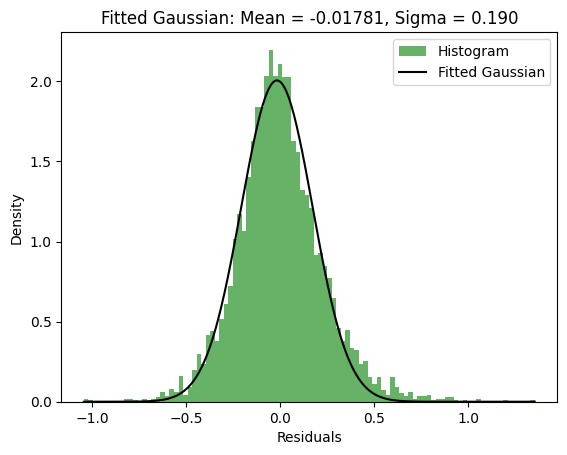

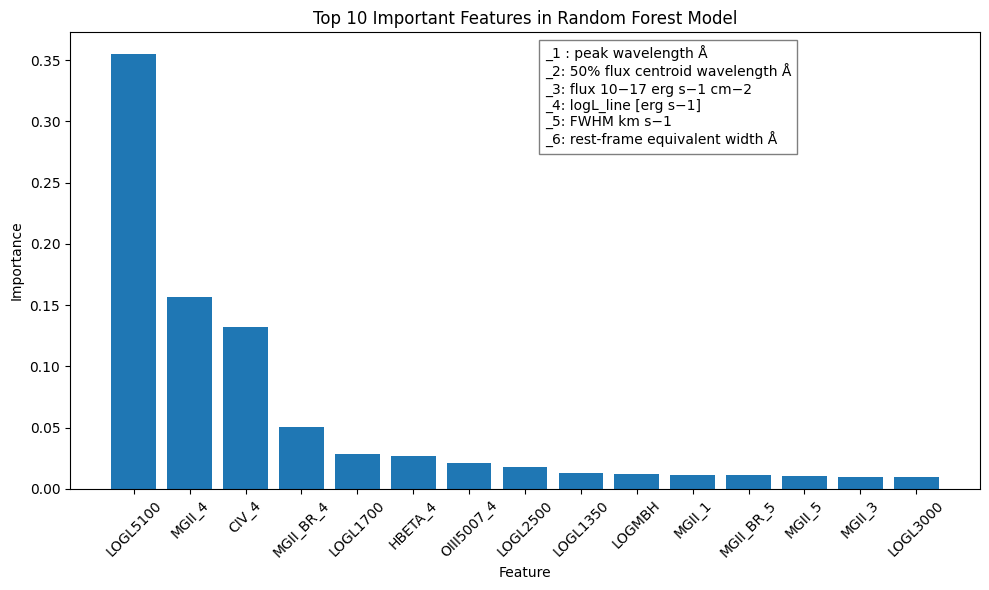

In [15]:
# Line of perfect prediction
min_val = min(y_test_original.min(), y_pred.min())
max_val = max(y_test_original.max(), y_pred.max())

# Plotting Predicted vs Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()

# --- 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

# Calculate residuals
residuals = y_pred.ravel() - y_test_original.ravel()


# Create histogram (binned data)
bin_heights, bin_borders, _ = plt.hist(residuals, bins=100, label='Histogram', density=True, alpha=0.6, color='g')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# Fit the Gaussian to the histogram data
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., max(bin_heights), np.std(residuals)])

# Plot the fitted Gaussian
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Fitted Gaussian', color='black')

# Annotate the plot with the Gaussian parameters
plt.title(f'Fitted Gaussian: Mean = {popt[0]:.5f}, Sigma = {popt[2]:.3f}')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

plt.show()

# --- 
# comment out the features you didn't include in the model
feature_names = [
    'LOGL1350', 
    'LOGL1700', 
    'LOGL2500', 
    'LOGL3000', 
    'LOGL5100', 
    # 'LOGLBOL', 
    'LOGMBH',
    'HALPHA_1', 'HALPHA_2', 'HALPHA_3', 'HALPHA_4', 'HALPHA_5', 'HALPHA_6',
    'HALPHA_BR_1', 'HALPHA_BR_2', 'HALPHA_BR_3', 'HALPHA_BR_4', 'HALPHA_BR_5', 'HALPHA_BR_6',
    'HBETA_1', 'HBETA_2', 'HBETA_3', 'HBETA_4', 'HBETA_5', 'HBETA_6',
    'HBETA_BR_1', 'HBETA_BR_2', 'HBETA_BR_3', 'HBETA_BR_4', 'HBETA_BR_5', 'HBETA_BR_6',
    'OIII5007_1', 'OIII5007_2', 'OIII5007_3', 'OIII5007_4', 'OIII5007_5', 'OIII5007_6',
    'OIII5007C_1', 'OIII5007C_2', 'OIII5007C_3', 'OIII5007C_4', 'OIII5007C_5', 'OIII5007C_6',
    'MGII_1', 'MGII_2', 'MGII_3', 'MGII_4', 'MGII_5', 'MGII_6',
    'MGII_BR_1', 'MGII_BR_2', 'MGII_BR_3', 'MGII_BR_4', 'MGII_BR_5', 'MGII_BR_6',
    'CIV_1', 'CIV_2', 'CIV_3', 'CIV_4', 'CIV_5', 'CIV_6'
]

# Get feature importances
importances = rf_regressor.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Select the top 10 features
top_k = 15
top_indices = indices[:top_k]

# Get the names and importances of the top features
top_feature_names = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(top_k), top_importances, align='center')
plt.xticks(range(top_k), top_feature_names, rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Important Features in Random Forest Model')
plt.tight_layout()

# Adding an inset with explanatory text (from Beta's mail)
text_str = (
    "_1 : peak wavelength Å\n"
    "_2: 50% flux centroid wavelength Å\n"
    "_3: flux 10−17 erg s−1 cm−2\n"
    "_4: logL_line [erg s−1]\n"
    "_5: FWHM km s−1\n"
    "_6: rest-frame equivalent width Å"
)
plt.gcf().text(0.55, 0.75, text_str, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()